In [4]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid 

from scipy.ndimage import generic_filter

In [1]:
#### this was not updated, the code and the plots are from an old version of the dataset

In [2]:
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
co2o2=xr.open_dataset(pathf+'3x3box_corr_monthly_co2-o2_0181-0190_noice.nc', chunks='auto')
jp=xr.open_dataset(pathf+'3x3box_corr_monthly_jp_uptake_0181-0190_noice.nc', chunks='auto')
mld=xr.open_dataset(pathf+'3x3box_corr_monthly_mld_0181-0190_noice.nc', chunks='auto')
corr_ctrl=xr.open_dataset(pathf+'3x3box_corr_monthly_0181-0190_noice.nc', chunks='auto')
corr_cc=xr.open_dataset(pathf+'3x3box_corr_monthly_1PctTo2X_0181-0190_noice.nc', chunks='auto')
co2o2=fix_grid(co2o2)
corr_ctrl=fix_grid(corr_ctrl)
corr_cc=fix_grid(corr_cc)
jp=fix_grid(jp)
mld=fix_grid(mld)

o2sst=corr_ctrl.corr_sst_o2_stf
co2sst=corr_ctrl.corr_sst_dic_stf
gases=co2o2.corr_o2_stf_dic_stf

data=xr.open_dataset(pathf+'3x3box_anomaly_monthly_0181-0190_noice.nc', chunks='auto')
data=fix_grid(data)

o2=data.o2_stf
co2=data.dic_stf
sst=data.SST

jpa=xr.open_dataset(pathf+'3x3box_anomaly_monthly_0181-0190_jp_noice.nc', chunks='auto')
mlda=xr.open_dataset(pathf+'3x3box_anomaly_mld_monthly_0181-0190_noice.nc', chunks='auto')
jpa=fix_grid(jpa)
mlda=fix_grid(mlda)

# numbers of global mean corr

In [17]:
def glob_mean(data):
    data=data.where(data<=1).where(data>=-1)
    weights = np.cos(np.deg2rad(data.yt_ocean))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("xt_ocean", "yt_ocean"))
    return weighted_mean.values

In [19]:
print('SSH-O2', glob_mean(corr_ctrl.corr_ssh_o2_stf))
print('SSH-CO2', glob_mean(corr_ctrl.corr_ssh_dic_stf))
print('SSH-sens heat', glob_mean(corr_ctrl.corr_ssh_sens_heat))
print('SSH-lat heat', glob_mean(corr_ctrl.corr_ssh_evap_heat))

print('SSH-SST', glob_mean(corr_ctrl.corr_sst_SSH))

print('SST-O2', glob_mean(corr_ctrl.corr_sst_o2_stf))
print('SST-CO2', glob_mean(corr_ctrl.corr_sst_dic_stf))
print('SST-sens heat', glob_mean(corr_ctrl.corr_sst_sens_heat))
print('SST-lat heat', glob_mean(corr_ctrl.corr_sst_evap_heat))

SSH-O2 0.16744177770410723
SSH-CO2 0.16389930497985328
SSH-sens heat -0.32858313503160275
SSH-lat heat -0.33531469004231096
SSH-SST 0.352707650360542
SST-O2 0.2068506851583656
SST-CO2 -0.012588869341322943
SST-sens heat -0.8607340967981219
SST-lat heat -0.9022547193714167


# gases

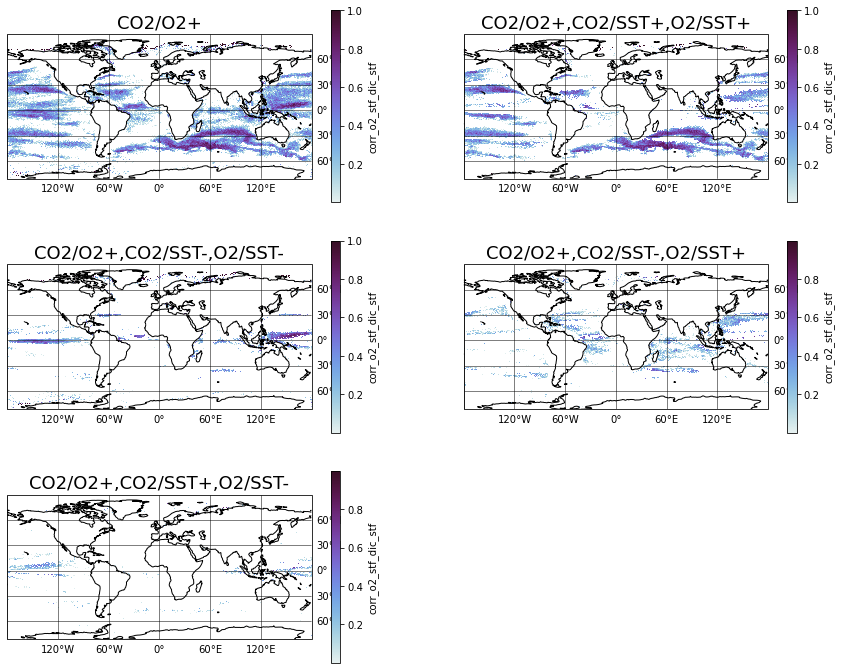

In [61]:
fig, axs= plt.subplots(nrows=3, ncols=2 , figsize=(15,12),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=gases.where(gases>0).plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cmo.dense, transform = ccrs.PlateCarree(),add_colorbar=True)
gases.where(gases>0).where(co2sst>0).where(o2sst>0).plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap=cmo.dense, transform = ccrs.PlateCarree(),add_colorbar=True)
gases.where(gases>0).where(co2sst<0).where(o2sst<0).plot(ax=axs[2], x='geolon_t', y='geolat_t', cmap=cmo.dense, transform = ccrs.PlateCarree(),add_colorbar=True)
gases.where(gases>0).where(co2sst<0).where(o2sst>0).plot(ax=axs[3], x='geolon_t', y='geolat_t', cmap=cmo.dense, transform = ccrs.PlateCarree(),add_colorbar=True)
gases.where(gases>0).where(co2sst>0).where(o2sst<0).plot(ax=axs[4], x='geolon_t', y='geolat_t', cmap=cmo.dense, transform = ccrs.PlateCarree(),add_colorbar=True)


for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()
    
axs[0].set_title('CO2/O2+', fontsize=18);
axs[1].set_title('CO2/O2+,CO2/SST+,O2/SST+', fontsize=18);
axs[2].set_title('CO2/O2+,CO2/SST-,O2/SST-', fontsize=18);
axs[3].set_title('CO2/O2+,CO2/SST-,O2/SST+', fontsize=18);
axs[4].set_title('CO2/O2+,CO2/SST+,O2/SST-', fontsize=18);

axs[5].set_axis_off()
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

In [136]:
test1=gases.where(gases>0).where(co2sst<0).where(o2sst>0)
test2=gases.where(gases>0).where(co2sst>0).where(o2sst<0)

In [137]:
loc1h=test1.where(test1>.6, drop=True)
loc1=loc1h.isel(xt_ocean=800)
loc1=loc1.where(loc1==loc1.max(), drop=True)
loc1=loc1h.where(loc1h==loc1.values, drop=True)

In [138]:
loc2h=test2.where(test2>.6, drop=True)
loc2=loc2h.isel(yt_ocean=200)
loc2=loc2.where(loc2==loc2.max(), drop=True)
loc2=loc2h.where(loc2h==loc2.values, drop=True)

In [112]:
loc1

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -100.6
  * yt_ocean  (yt_ocean) float64 17.0
    geolon_t  (yt_ocean, xt_ocean) float64 -100.6
    geolat_t  (yt_ocean, xt_ocean) float64 17.0

In [111]:
loc2

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -258.7
  * yt_ocean  (yt_ocean) float64 12.55
    geolon_t  (yt_ocean, xt_ocean) float64 -258.7
    geolat_t  (yt_ocean, xt_ocean) float64 12.55

In [139]:
o21=o2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
o22=o2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [140]:
co21=co2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
co22=co2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [141]:
sst1=sst.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
sst2=sst.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

Text(0, 0.5, 'FO2')

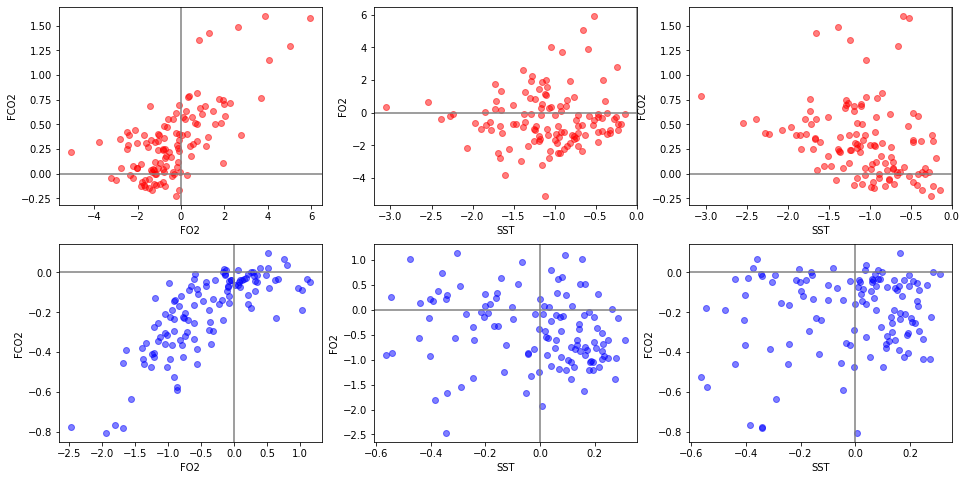

In [194]:
fig,axs=plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs=axs.flatten()
axs[0].scatter(o21, co21, alpha=.5, c='r')
axs[1].scatter(sst1,o21,  alpha=.5, c='r')
axs[2].scatter(sst1,co21, alpha=.5, c='r')

axs[3].scatter(o22, co22, alpha=.5, c='b')
axs[4].scatter(sst2,o22,  alpha=.5, c='b')
axs[5].scatter(sst2,co22, alpha=.5, c='b')

for i in range (6):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')

axs[0].set_xlabel('FO2')
axs[3].set_xlabel('FO2')
axs[1].set_xlabel('SST')
axs[2].set_xlabel('SST')
axs[4].set_xlabel('SST')
axs[5].set_xlabel('SST')

axs[0].set_ylabel('FCO2')
axs[2].set_ylabel('FCO2')
axs[3].set_ylabel('FCO2')
axs[5].set_ylabel('FCO2')
axs[1].set_ylabel('FO2')
axs[4].set_ylabel('FO2')

In [190]:
print(gases.where(loc1).values)
print(corr_ctrl.corr_sst_o2_stf.where(loc1).values)
print(corr_ctrl.corr_sst_dic_stf.where(loc1).values)

[[0.6823445]]
[[0.0530383]]
[[-0.27680408]]


In [191]:
print(gases.where(loc2).values)
print(corr_ctrl.corr_sst_o2_stf.where(loc2).values)
print(corr_ctrl.corr_sst_dic_stf.where(loc2).values)

[[0.77185888]]
[[-0.17424378]]
[[0.15205685]]


In [197]:
print(xr.corr(co2.where(loc1), o2.where(loc1)).values)
print(xr.corr(o2.where(loc1), sst.where(loc1)).values)
print(xr.corr(co2.where(loc1), sst.where(loc1)).values)

print(xr.corr(co2.where(loc2), o2.where(loc2)).values)
print(xr.corr(o2.where(loc2), sst.where(loc2)).values)
print(xr.corr(co2.where(loc2), sst.where(loc2)).values)

0.6823445048428198
0.0530382951749326
-0.27680411694163215
0.7718591669817731
-0.17424378136338778
0.15205684391741606


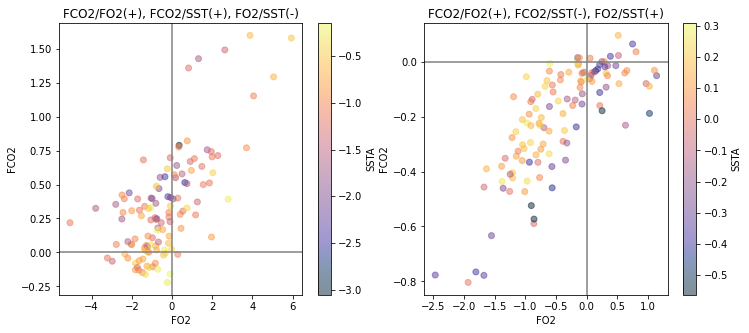

In [142]:
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs=axs.flatten()
o=axs[0].scatter(o21, co21, alpha=.5, c=sst1, cmap=cmo.thermal)
p=axs[1].scatter(o22, co22, alpha=.5, c=sst2, cmap=cmo.thermal)
for i in range (2):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')
    axs[i].set_xlabel('FO2')
    axs[i].set_ylabel('FCO2')
axs[0].set_title('FCO2/FO2(+), FCO2/SST(+), FO2/SST(-)')
axs[1].set_title('FCO2/FO2(+), FCO2/SST(-), FO2/SST(+)')

fig.colorbar(o, ax=axs[0], label='SSTA')
fig.colorbar(p, ax=axs[1], label='SSTA')
#cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
#cbar=fig.colorbar(o, cax=cbar_ax,orientation='horizontal', label='SSTA in °C')

# jp (not up to date)

In [7]:
bioup=gases.where(gases<0)

In [9]:
jpo2=jp.corr_jp_o2_stf_ctrl
jpco2=jp.corr_jp_dic_stf_ctrl

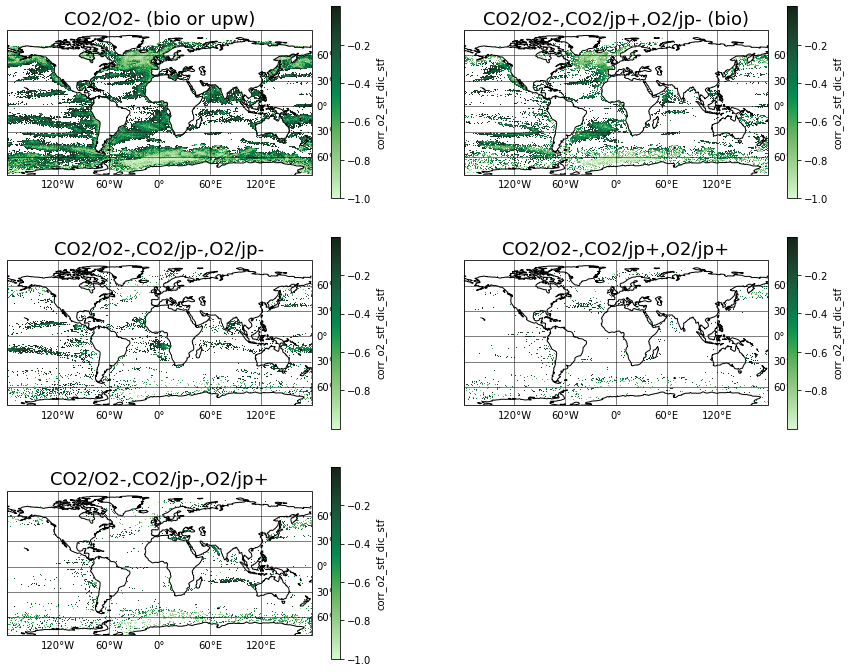

In [14]:
fig, axs= plt.subplots(nrows=3, ncols=2 , figsize=(15,12),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=bioup.plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(jpo2<0).where(jpco2>0).plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(jpo2<0).where(jpco2<0).plot(ax=axs[2], x='geolon_t', y='geolat_t', cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(jpo2>0).where(jpco2>0).plot(ax=axs[3], x='geolon_t', y='geolat_t', cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(jpo2>0).where(jpco2<0).plot(ax=axs[4], x='geolon_t', y='geolat_t', cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)


for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()
    
axs[0].set_title('CO2/O2- (bio or upw)', fontsize=18);
axs[1].set_title('CO2/O2-,CO2/jp+,O2/jp- (bio)', fontsize=18);
axs[2].set_title('CO2/O2-,CO2/jp-,O2/jp-', fontsize=18);
axs[3].set_title('CO2/O2-,CO2/jp+,O2/jp+', fontsize=18);
axs[4].set_title('CO2/O2-,CO2/jp-,O2/jp+', fontsize=18);

axs[5].set_axis_off()
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

In [143]:
test1=bioup.where(jpo2>0).where(jpco2>0)
test2=bioup.where(jpo2<0).where(jpco2<0)

In [144]:
loc1h=test1.where(test1<-.6, drop=True)
loc1=loc1h.isel(xt_ocean=800)
loc1=loc1.where(loc1==loc1.max(), drop=True)
loc1=loc1h.where(loc1h==loc1.values, drop=True)

In [145]:
loc2h=test2.where(test2<-.6, drop=True)
loc2=loc2h.isel(yt_ocean=1000)
loc2=loc2.where(loc2==loc2.max(), drop=True)
loc2=loc2h.where(loc2h==loc2.values, drop=True)

In [116]:
loc1

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -197.3
  * yt_ocean  (yt_ocean) float64 -57.13
    geolon_t  (yt_ocean, xt_ocean) float64 -197.3
    geolat_t  (yt_ocean, xt_ocean) float64 -57.13

In [117]:
loc2

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -75.35
  * yt_ocean  (yt_ocean) float64 -20.78
    geolon_t  (yt_ocean, xt_ocean) float64 -75.35
    geolat_t  (yt_ocean, xt_ocean) float64 -20.78

In [58]:
jpa=jpa.jp_uptake

In [146]:
o21=o2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
o22=o2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [147]:
co21=co2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
co22=co2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [148]:
jpa1=jpa.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
jpa2=jpa.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [70]:
print(gases.where(loc1).values)
print(jp.corr_jp_o2_stf_ctrl.where(loc1).values)
print(jp.corr_jp_dic_stf_ctrl.where(loc1).values)

[[-0.60211126]]
[[0.09994666]]
[[0.10601718]]


In [71]:
print(gases.where(loc2).values)
print(jp.corr_jp_o2_stf_ctrl.where(loc2).values)
print(jp.corr_jp_dic_stf_ctrl.where(loc2).values)

[[-0.6844973]]
[[-0.1312187]]
[[-0.01324493]]


In [73]:
print(xr.corr(co2.where(loc1), o2.where(loc1)).values)
print(xr.corr(o2.where(loc1), jpa.where(loc1)).values)
print(xr.corr(co2.where(loc1), jpa.where(loc1)).values)

print(xr.corr(co2.where(loc2), o2.where(loc2)).values)
print(xr.corr(o2.where(loc2), jpa.where(loc2)).values)
print(xr.corr(co2.where(loc2), jpa.where(loc2)).values)

-0.6021110693783366
0.09994664799211375
0.10601716487976857
-0.6844974038759604
-0.13121869292200408
-0.013244932428497601


Text(0, 0.5, 'FO2')

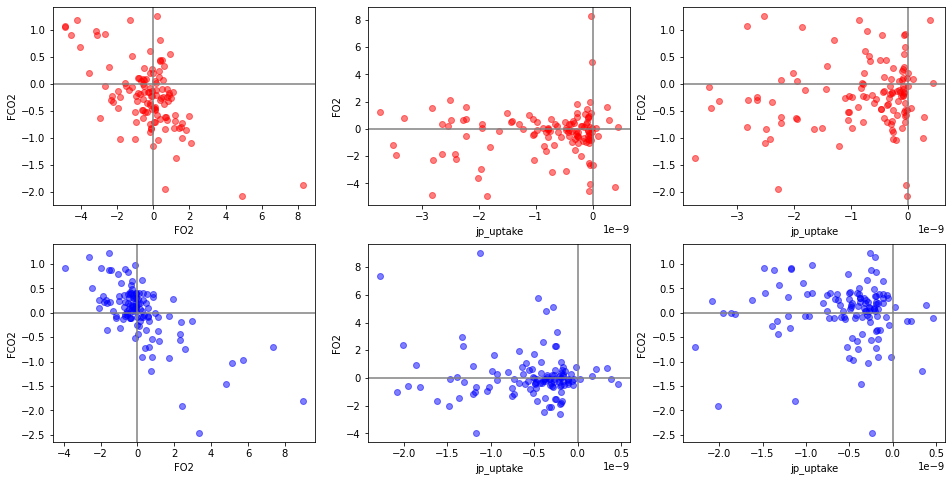

In [72]:
fig,axs=plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs=axs.flatten()
axs[0].scatter(o21, co21, alpha=.5, c='r')
axs[1].scatter(jpa1,o21,  alpha=.5, c='r')
axs[2].scatter(jpa1,co21, alpha=.5, c='r')

axs[3].scatter(o22, co22, alpha=.5, c='b')
axs[4].scatter(jpa2,o22,  alpha=.5, c='b')
axs[5].scatter(jpa2,co22, alpha=.5, c='b')

for i in range (6):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')

axs[0].set_xlabel('FO2')
axs[3].set_xlabel('FO2')
axs[1].set_xlabel('jp_uptake')
axs[2].set_xlabel('jp_uptake')
axs[4].set_xlabel('jp_uptake')
axs[5].set_xlabel('jp_uptake')

axs[0].set_ylabel('FCO2')
axs[2].set_ylabel('FCO2')
axs[3].set_ylabel('FCO2')
axs[5].set_ylabel('FCO2')
axs[1].set_ylabel('FO2')
axs[4].set_ylabel('FO2')

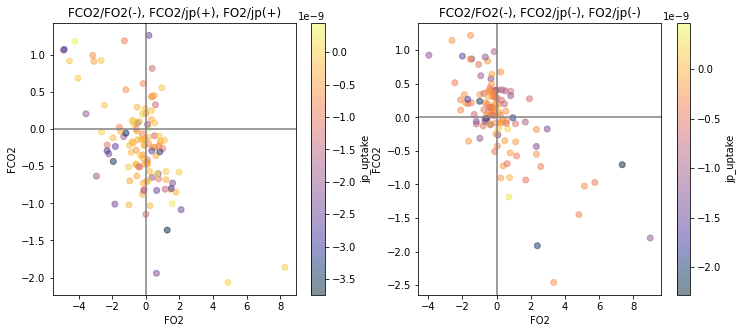

In [149]:
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs=axs.flatten()
o=axs[0].scatter(o21, co21, alpha=.5, c=jpa1, cmap=cmo.thermal)
p=axs[1].scatter(o22, co22, alpha=.5, c=jpa2, cmap=cmo.thermal)
for i in range (2):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')
    axs[i].set_xlabel('FO2')
    axs[i].set_ylabel('FCO2')
axs[0].set_title('FCO2/FO2(-), FCO2/jp(+), FO2/jp(+)')
axs[1].set_title('FCO2/FO2(-), FCO2/jp(-), FO2/jp(-)')

fig.colorbar(o, ax=axs[0], label='jp_uptake')
fig.colorbar(p, ax=axs[1], label='jp_uptake')

# mld

In [12]:
mldo2=mld.corr_mld_o2_stf_ctrl
mldco2=mld.corr_mld_dic_stf_ctrl

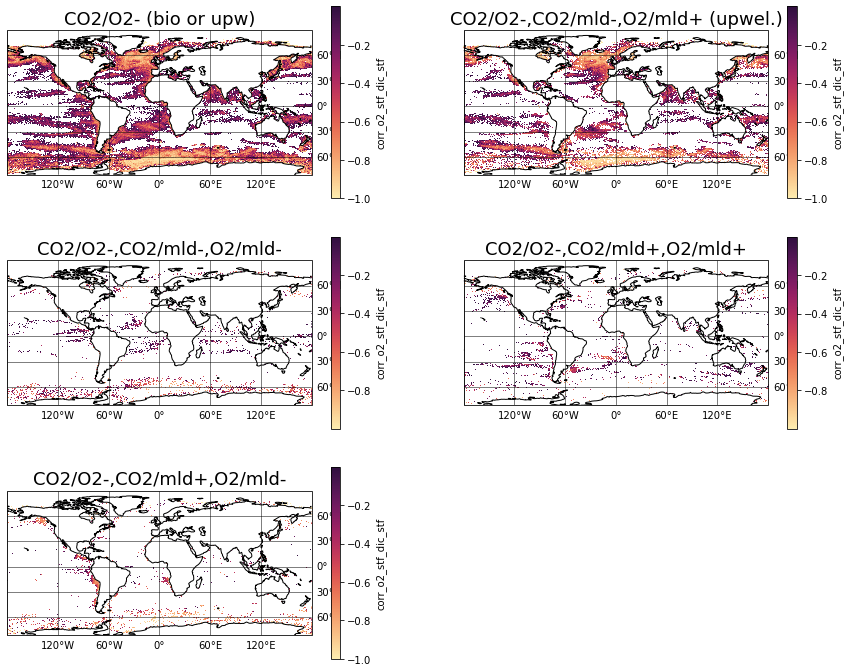

In [15]:
fig, axs= plt.subplots(nrows=3, ncols=2 , figsize=(15,12),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=bioup.plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cmo.matter, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(mldo2>0).where(mldco2<0).plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap=cmo.matter, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(mldo2<0).where(mldco2<0).plot(ax=axs[2], x='geolon_t', y='geolat_t', cmap=cmo.matter, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(mldo2>0).where(mldco2>0).plot(ax=axs[3], x='geolon_t', y='geolat_t', cmap=cmo.matter, transform = ccrs.PlateCarree(),add_colorbar=True)
bioup.where(mldo2<0).where(mldco2>0).plot(ax=axs[4], x='geolon_t', y='geolat_t', cmap=cmo.matter, transform = ccrs.PlateCarree(),add_colorbar=True)


for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()
    
axs[0].set_title('CO2/O2- (bio or upw)', fontsize=18);
axs[1].set_title('CO2/O2-,CO2/mld-,O2/mld+', fontsize=18);
axs[2].set_title('CO2/O2-,CO2/mld-,O2/mld-', fontsize=18);
axs[3].set_title('CO2/O2-,CO2/mld+,O2/mld+', fontsize=18);
axs[4].set_title('CO2/O2-,CO2/mld+,O2/mld- (upwel.)', fontsize=18);

axs[5].set_axis_off()
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

In [150]:
test1=bioup.where(mldo2>0).where(mldco2>0)
test2=bioup.where(mldo2<0).where(mldco2<0)

In [151]:
loc1h=test1.where(test1<-.6, drop=True)
loc1=loc1h.isel(yt_ocean=800)
loc1=loc1.where(loc1==loc1.max(), drop=True)
loc1=loc1h.where(loc1h==loc1.values, drop=True)

In [152]:
loc2h=test2.where(test2<-.6, drop=True)
loc2=loc2h.isel(yt_ocean=1000)
loc2=loc2.where(loc2==loc2.max(), drop=True)
loc2=loc2h.where(loc2h==loc2.values, drop=True)

In [121]:
loc1

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -180.9
  * yt_ocean  (yt_ocean) float64 -37.61
    geolon_t  (yt_ocean, xt_ocean) float64 -180.9
    geolat_t  (yt_ocean, xt_ocean) float64 -37.61

In [122]:
loc2

<xarray.DataArray 'corr_o2_stf_dic_stf' (yt_ocean: 1, xt_ocean: 1)>
dask.array<where, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12.25
  * yt_ocean  (yt_ocean) float64 -12.06
    geolon_t  (yt_ocean, xt_ocean) float64 12.25
    geolat_t  (yt_ocean, xt_ocean) float64 -12.06

In [81]:
mlda=mlda.mld

In [153]:
o21=o2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
o22=o2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [154]:
co21=co2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
co22=co2.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [155]:
mlda1=mlda.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
mlda2=mlda.where(loc2).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

In [104]:
print(gases.where(loc1).values)
print(mld.corr_mld_o2_stf_ctrl.where(loc1).values)
print(mld.corr_mld_dic_stf_ctrl.where(loc1).values)

[[-0.60546074]]
[[0.13123141]]
[[0.14139723]]


In [88]:
print(gases.where(loc2).values)
print(mld.corr_mld_o2_stf_ctrl.where(loc2).values)
print(mld.corr_mld_dic_stf_ctrl.where(loc2).values)

[[-0.60657714]]
[[-0.04268382]]
[[-0.01349761]]


In [105]:
print(xr.corr(co2.where(loc1), o2.where(loc1)).values)
print(xr.corr(o2.where(loc1), mlda.where(loc1)).values)
print(xr.corr(co2.where(loc1), mlda.where(loc1)).values)

print(xr.corr(co2.where(loc2), o2.where(loc2)).values)
print(xr.corr(o2.where(loc2), mlda.where(loc2)).values)
print(xr.corr(co2.where(loc2), mlda.where(loc2)).values)

-0.6054607879899214
0.1312314071563655
0.14139727423586565
-0.6065771340326961
-0.04268381187907131
-0.013497586497772432


Text(0, 0.5, 'FO2')

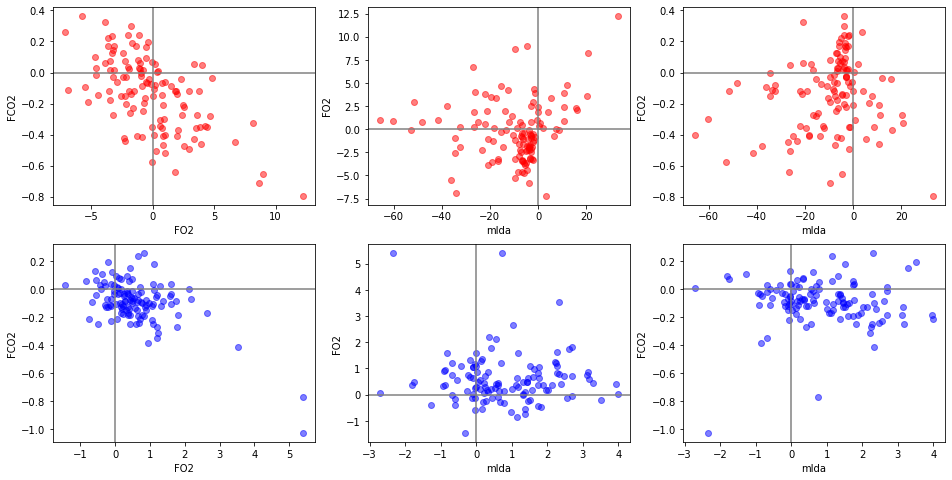

In [106]:
fig,axs=plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs=axs.flatten()
axs[0].scatter(o21, co21, alpha=.5, c='r')
axs[1].scatter(mlda1,o21,  alpha=.5, c='r')
axs[2].scatter(mlda1,co21, alpha=.5, c='r')

axs[3].scatter(o22, co22, alpha=.5, c='b')
axs[4].scatter(mlda2,o22,  alpha=.5, c='b')
axs[5].scatter(mlda2,co22, alpha=.5, c='b')

for i in range (6):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')

axs[0].set_xlabel('FO2')
axs[3].set_xlabel('FO2')
axs[1].set_xlabel('mlda')
axs[2].set_xlabel('mlda')
axs[4].set_xlabel('mlda')
axs[5].set_xlabel('mlda')

axs[0].set_ylabel('FCO2')
axs[2].set_ylabel('FCO2')
axs[3].set_ylabel('FCO2')
axs[5].set_ylabel('FCO2')
axs[1].set_ylabel('FO2')
axs[4].set_ylabel('FO2')

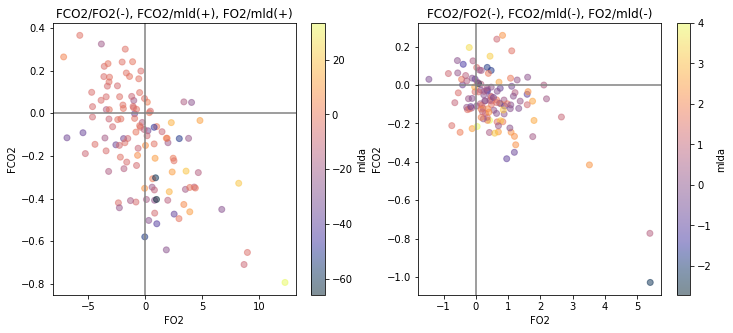

In [156]:
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs=axs.flatten()
o=axs[0].scatter(o21, co21, alpha=.5, c=mlda1, cmap=cmo.thermal)
p=axs[1].scatter(o22, co22, alpha=.5, c=mlda2, cmap=cmo.thermal)
for i in range (2):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')
    axs[i].set_xlabel('FO2')
    axs[i].set_ylabel('FCO2')
axs[0].set_title('FCO2/FO2(-), FCO2/mld(+), FO2/mld(+)')
axs[1].set_title('FCO2/FO2(-), FCO2/mld(-), FO2/mld(-)')

fig.colorbar(o, ax=axs[0], label='mlda')
fig.colorbar(p, ax=axs[1], label='mlda')

# keine Dreiecksbeziehung

In [3]:
gut=gases.where(gases>0).where(co2sst>0).where(o2sst>0)

In [10]:
loc1h=gut.where(gut>.6, drop=True)
loc1=loc1h.isel(xt_ocean=400)
loc1=loc1.where(loc1==loc1.max(), drop=True)
loc1=loc1h.where(loc1h==loc1.values, drop=True)

In [11]:
o21=o2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
co21=co2.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')
sst1=sst.where(loc1).squeeze(dim='xt_ocean').squeeze(dim='yt_ocean')

Text(0, 0.5, 'FO2')

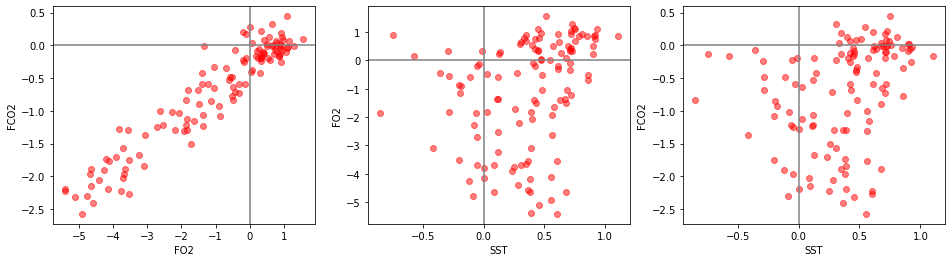

In [12]:
fig,axs=plt.subplots(nrows=1, ncols=3, figsize=(16,4))
axs=axs.flatten()
axs[0].scatter(o21, co21, alpha=.5, c='r')
axs[1].scatter(sst1,o21,  alpha=.5, c='r')
axs[2].scatter(sst1,co21, alpha=.5, c='r')

for i in range (3):
    axs[i].axvline(0, c='gray')
    axs[i].axhline(0, c='gray')

axs[0].set_xlabel('FO2')
axs[1].set_xlabel('SST')
axs[2].set_xlabel('SST')

axs[0].set_ylabel('FCO2')
axs[2].set_ylabel('FCO2')
axs[1].set_ylabel('FO2')

In [13]:
print(gases.where(loc1).values)
print(corr_ctrl.corr_sst_o2_stf.where(loc1).values)
print(corr_ctrl.corr_sst_dic_stf.where(loc1).values)

[[0.94985849]]
[[0.29702356]]
[[0.30304677]]


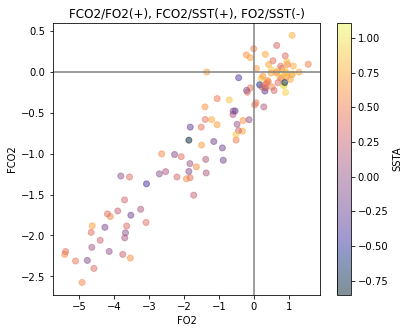

In [15]:
fig,axs=plt.subplots(nrows=1, ncols=1, figsize=(6,5))
o=axs.scatter(o21, co21, alpha=.5, c=sst1, cmap=cmo.thermal)
axs.axvline(0, c='gray')
axs.axhline(0, c='gray')
axs.set_xlabel('FO2')
axs.set_ylabel('FCO2')
axs.set_title('FCO2/FO2(+), FCO2/SST(+), FO2/SST(-)')

fig.colorbar(o, ax=axs, label='SSTA')
#cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
#cbar=fig.colorbar(o, cax=cbar_ax,orientation='horizontal', label='SSTA in °C')